In [1]:
import sys; sys.path.append('../')
import warnings
warnings.filterwarnings('ignore')
import pickle

from glob import glob
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

In [2]:
plt.figure(figsize=(20,30))
res_paths = glob('../model_selection/results/*results.pickle')
n_cols_plots = 3
n_rows_plots = (len(res_paths) // n_cols_plots) + 1

all_results = []

for i, path in enumerate(res_paths):
    path = Path(path)
    with open(path, 'rb') as fh:
        results, *_ = pickle.load(fh)
        
    results = pd.DataFrame(results)
    all_results.append(results)
    
    plt.subplot(n_rows_plots, n_cols_plots, i + 1)
    x = list(range(len(results)))
    plt.errorbar(x, results.mean_train_score, results.std_train_score, label='train')
    plt.errorbar(x, results.mean_test_score, results.std_test_score, label='test')
    plt.legend()
    plt.title(path.name)

<Figure size 1440x2160 with 0 Axes>

In [3]:
best_result = 0
best_method = None

for result in all_results:
    res = max(result.mean_test_score)
    if res > best_result:
        best_result = res
        best_method = result.columns
print(best_method, best_result)

None 0


## Baseline

Using TensorFlow backend.
2019-12-09 18:36:36,704:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}")
2019-12-09 18:36:37,436:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}")
2019-12-09 18:36:39,991:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}")
2019-12-09 18:36:40,544:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}")
2019-12-09 18:36:41,968:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}")
2019-12-09 18:36:42,520:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs':

0.7079545454545455


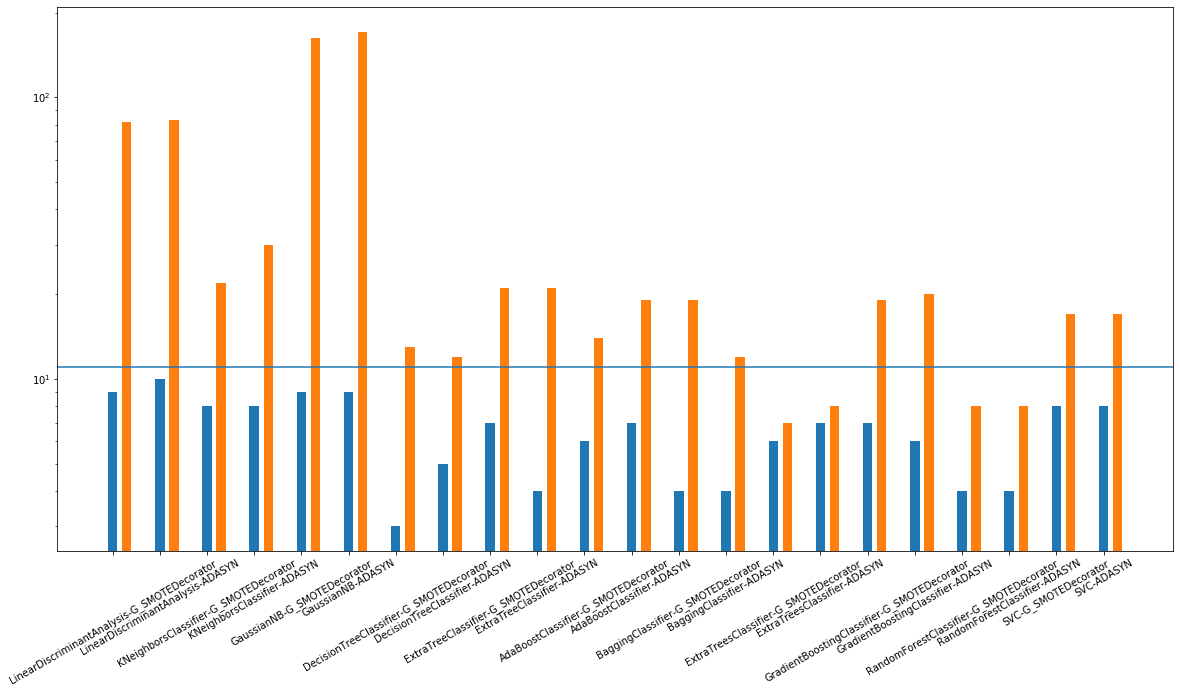

In [4]:
from src.evaluation import imbalanced_score, matthews_corrcoef_score

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier, RandomForestClassifier)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from src.oversampling import G_SMOTEDecorator

from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
models = [
    LinearDiscriminantAnalysis, KNeighborsClassifier, GaussianNB,
    DecisionTreeClassifier, ExtraTreeClassifier, AdaBoostClassifier, BaggingClassifier,
    ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, SVC
]

X = pd.read_csv('../data/all_X.csv')
y = pd.read_csv('../data/all_y.csv', header=None).T.ix[0]

i_train, i_test = next(StratifiedShuffleSplit(test_size=0.2, random_state=40).split(X, y))

X_train, X_test, y_train, y_test = X.loc[i_train], X.loc[i_test], y.loc[i_train], y.loc[i_test]

tps, ts, gts, labels, scores = [], [], [], [], []
for Model in models:
    for oversampler in [G_SMOTEDecorator(), ADASYN()]:
        pipeline = Pipeline([
            ('OVERSAMPLER', oversampler), (Model.__name__, Model())
        ])
        clf = pipeline.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        tps.append(sum(y_test & y_pred))
        ts.append(sum(y_pred))
        gts.append(sum(y_test))
        labels.append(f'{Model.__name__}-{oversampler.__class__.__name__}')
        scores.append(imbalanced_score(0.7)(clf, X_test, y_test))

plt.figure(figsize=(20,10))
x = np.arange(len(tps))

plt.bar(x, tps, width=0.2)
plt.bar(x + 0.3, ts, width=0.2)

plt.xticks(x, labels, rotation=30)
plt.yscale('log')
plt.axhline(gts[0])
print(max(scores))

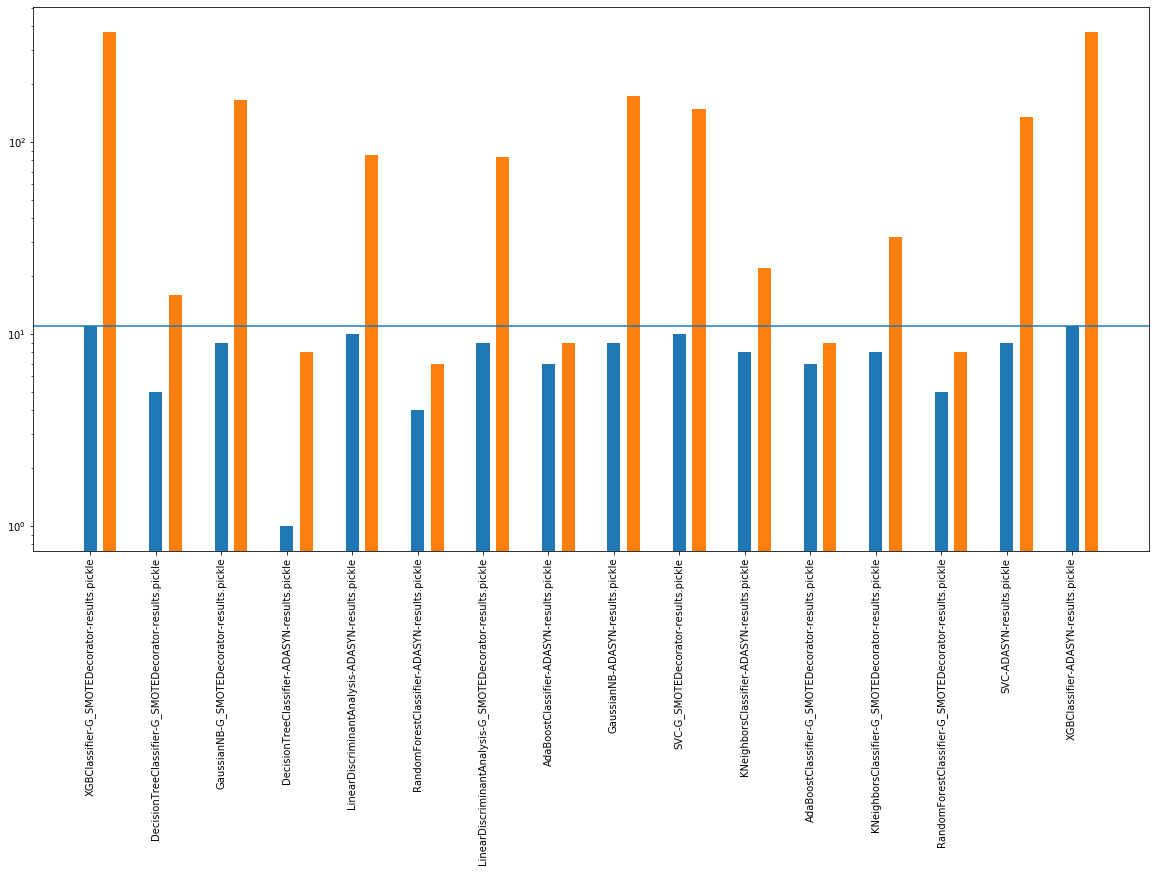

In [5]:
res_paths = glob('../experiments/model_selection/results/*results.pickle')
n_cols_plots = 3
n_rows_plots = (len(res_paths) // n_cols_plots) + 1

tps, ts, gts, labels = [], [], [], []
for i, path in enumerate(res_paths):
    path = Path(path)
    with open(path, 'rb') as fh:
        results, y_true, y_pred = pickle.load(fh)
    tps.append(sum(y_true & y_pred))
    ts.append(sum(y_pred))
    gts.append(sum(y_true))
    labels.append(path.name)

plt.figure(figsize=(20,10))
x = np.arange(len(tps))

plt.bar(x, tps, width=0.2)
plt.bar(x + 0.3, ts, width=0.2)

plt.xticks(x, labels, rotation=90)
plt.yscale('log')
plt.axhline(gts[0])

In [6]:
res_paths = glob('../experiments/model_selection/results/*.pickle')
test_scores = {}

for i, path in enumerate(res_paths):
    path = Path(path)
    if 'results' in path.name: continue
    with open(path, 'rb') as fh:
        conf = pickle.load(fh)
    with open(str(path).rsplit('.', 1)[0] + '-results.pickle', 'rb') as fh:
        results, *_ = pickle.load(fh)
    
    results = pd.DataFrame(results)
    scores = results[results.params == conf].filter(regex='split\d_test*').values
    if len(scores) != 0:
        test_scores[path.name.rsplit('.', 1)[0]] = scores[0]
    else:
        test_scores[path.name.rsplit('.', 1)[0]] =\
            results[results.params.apply(lambda d: d.get('AdaBoostClassifier__n_estimators', None)) == conf['AdaBoostClassifier__n_estimators']]\
                .filter(regex='split\d_test*').values[0]
test_scores = list(test_scores.items())
test_scores = sorted(test_scores, key = lambda l: l[1].mean(), reverse=True)

In [7]:
sorted([(k, v.mean()) for k, v in test_scores], key = lambda l: l[1], reverse=True)

[('AdaBoostClassifier-ADASYN', 0.7272619047619047),
 ('SVC-G_SMOTEDecorator', 0.7131035324965163),
 ('SVC-ADASYN', 0.7102381794878688),
 ('XGBClassifier-G_SMOTEDecorator', 0.709172935905855),
 ('XGBClassifier-ADASYN', 0.7090151982878391),
 ('KNeighborsClassifier-G_SMOTEDecorator', 0.700574225058096),
 ('LinearDiscriminantAnalysis-ADASYN', 0.6953928429027114),
 ('KNeighborsClassifier-ADASYN', 0.6910368166793796),
 ('LinearDiscriminantAnalysis-G_SMOTEDecorator', 0.6817546900800432),
 ('AdaBoostClassifier-G_SMOTEDecorator', 0.6773888888888889),
 ('GaussianNB-ADASYN', 0.6540295537395975),
 ('GaussianNB-G_SMOTEDecorator', 0.6390792569631382),
 ('RandomForestClassifier-ADASYN', 0.6155050505050504),
 ('RandomForestClassifier-G_SMOTEDecorator', 0.5576587301587301),
 ('DecisionTreeClassifier-ADASYN', 0.5281678876678877),
 ('DecisionTreeClassifier-G_SMOTEDecorator', 0.4866680541680541)]

In [8]:
from scipy.stats import friedmanchisquare

for n1, s1 in test_scores:
    print(n1)
    for n2, s2 in test_scores:
        if n1 != n2:
            print(n2, end='->')
            measurements = np.column_stack((s1, s2))
            print(*friedmanchisquare(*measurements))
    print('\n\n')

AdaBoostClassifier-ADASYN
SVC-G_SMOTEDecorator->2.8000000000000043 0.5918327134598548
SVC-ADASYN->3.6000000000000014 0.46283688702044234
XGBClassifier-G_SMOTEDecorator->4.400000000000006 0.35457010675946776
XGBClassifier-ADASYN->5.200000000000003 0.2673848815716016
KNeighborsClassifier-G_SMOTEDecorator->7.600000000000001 0.1073797049095948
LinearDiscriminantAnalysis-ADASYN->7.600000000000001 0.1073797049095948
KNeighborsClassifier-ADASYN->7.600000000000001 0.1073797049095948
LinearDiscriminantAnalysis-G_SMOTEDecorator->5.200000000000003 0.2673848815716016
AdaBoostClassifier-G_SMOTEDecorator->7.600000000000001 0.1073797049095948
GaussianNB-ADASYN->6.400000000000006 0.17120125670913774
GaussianNB-G_SMOTEDecorator->5.200000000000003 0.2673848815716016
RandomForestClassifier-ADASYN->6.400000000000006 0.17120125670913774
RandomForestClassifier-G_SMOTEDecorator->7.600000000000001 0.1073797049095948
DecisionTreeClassifier-ADASYN->4.205128205128207 0.3789559895897202
DecisionTreeClassifier-G_S